# Анализ Maise данных

## Загрузка данных

### Анализируемые данные
- `T1` - данные с сервера T1, где размер буффера 8 мб
- `T3` - данные с сервера Т3, где стандартный размер буффера

Потоки `trade` и `level` для инструментов `BTCUSDT` и `1000PEPEUSDT` за 18.01.2025

In [208]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

# USE_COLS - используемые столбцы
# SECTION - секция на бирже
# SECURITIES - инструменты
# STREAMS - потоки данных
USE_COLS=["receive_ts", "exchange_ts"]
SECTION = "BINANCE_USDM"
SECURITIES = ["BTCUSDT", "1000PEPEUSDT"]
SERVERS = ["T1", "T3"]
STREAMS = ["trade", "level"]
DATA_DIR = Path("data")
# Получение путей к данным из /data/{SERVER}/{SECTION}/{SECURITY}/{STREAM}.csv

data_paths = {
    security: {
        stream: {
            server: DATA_DIR / server / SECTION / security / f"{stream}.csv"
            for server in SERVERS
        }
        for stream in STREAMS
    }
    for security in SECURITIES
}


На данном этапе мы загрузили данные с серверов T1 и T3, где размер буффера 8 мб и стандартный размер буффера соответственно. Данные представлены в виде потоков `trade` и `level` для инструментов `BTCUSDT` и `1000PEPEUSDT` за 18.01.2025.

Данные можно получить из переменной `data_paths`:
например, данные для инструмента `BTCUSDT` и потока `trade` с сервера T1:
```python
data_paths["BTCUSDT"]["trade"]["T1"]
```

In [209]:
# Загрузим данные в Pandas DataFrame для дальнейшего анализа

# data = {
#     security: {
#         stream: {
#             server: pd.read_csv(path, usecols=USE_COLS, delimiter=";")
#             for server, path in paths.items()
#         }
#         for stream, paths in paths.items()
#     }
#     for security, paths in data_paths.items()
# }

trade_data = {
    security: {
        server: pd.read_csv(data_paths[security]["trade"][server], usecols=USE_COLS, delimiter=";")
        for server in SERVERS
    }
    for security in SECURITIES
}


In [210]:
# Пример загруженных данных
trade_data["BTCUSDT"]["T1"].head()

,receive_ts,exchange_ts
0,1737158405369050,1737158405365000
1,1737158405375052,1737158405371000
2,1737158405377660,1737158405376000
3,1737158405383222,1737158405381000
4,1737158405402041,1737158405402000


In [211]:
# Приведем данные к формату datetime

for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server]["receive_ts"] = pd.to_datetime(trade_data[security][server]["receive_ts"], unit="us")
        trade_data[security][server]["exchange_ts"] = pd.to_datetime(trade_data[security][server]["exchange_ts"], unit="us")


In [212]:
# Рассчитаем Jitter для данных (разницы receive_ts и exchange_ts)

for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server]["jitter"] = (trade_data[security][server]["receive_ts"] - trade_data[security][server]["exchange_ts"]).dt.total_seconds()


In [213]:
# Пример рассчитанного Jitter
trade_data["1000PEPEUSDT"]["T3"]["jitter"].sort_values().median()

np.float64(0.002017)

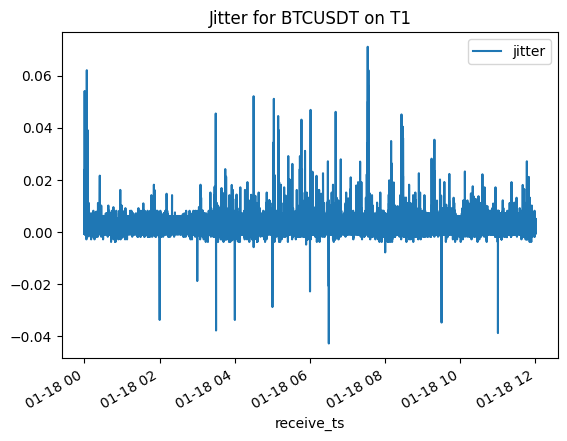

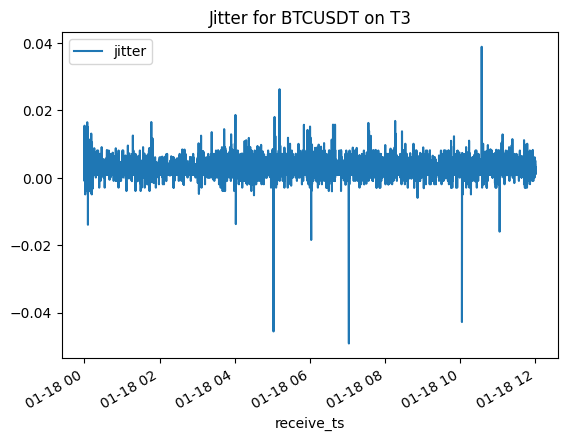

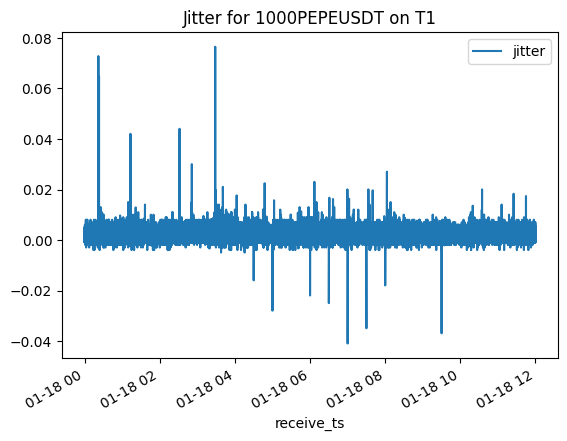

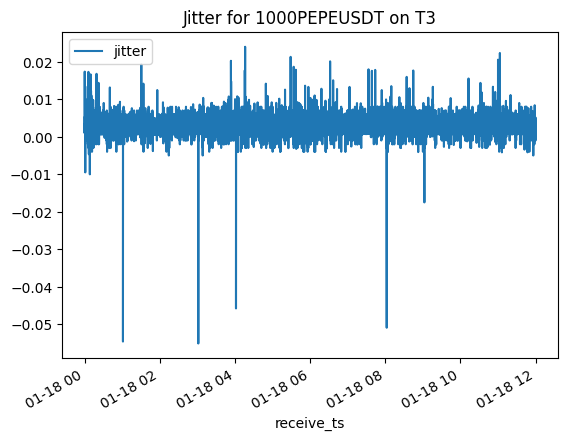

In [214]:
# Построим график Jitter для данных
for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server].plot(x="receive_ts", y="jitter", title=f"Jitter for {security} on {server}")
        plt.show()

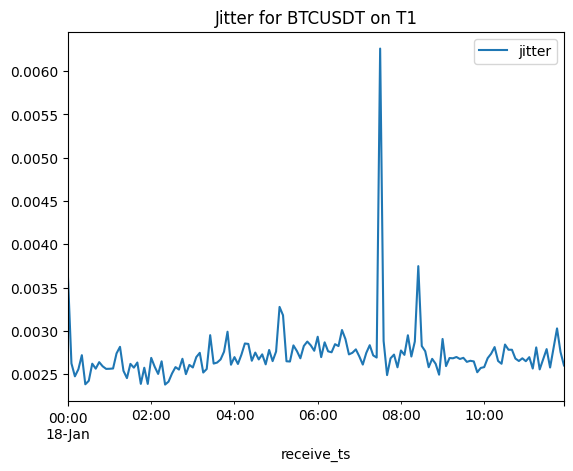

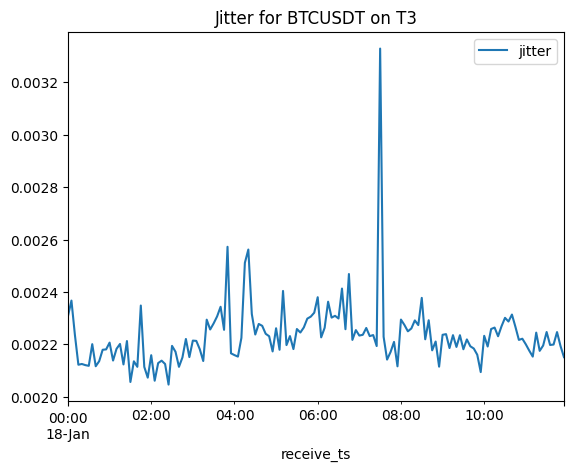

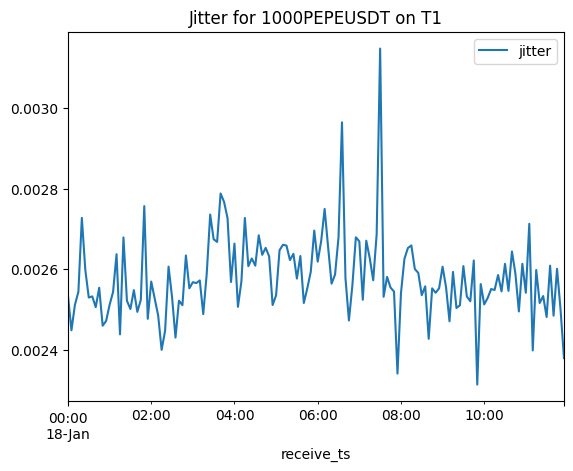

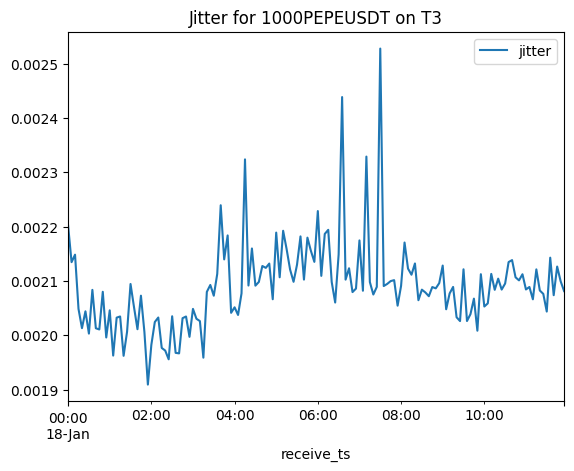

In [215]:
# Построим агрегированный график Jitter для данных по 5 минутам

for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server].resample("5min", on="receive_ts").mean(numeric_only=False).plot(y="jitter", title=f"Jitter for {security} on {server}")
        plt.show()

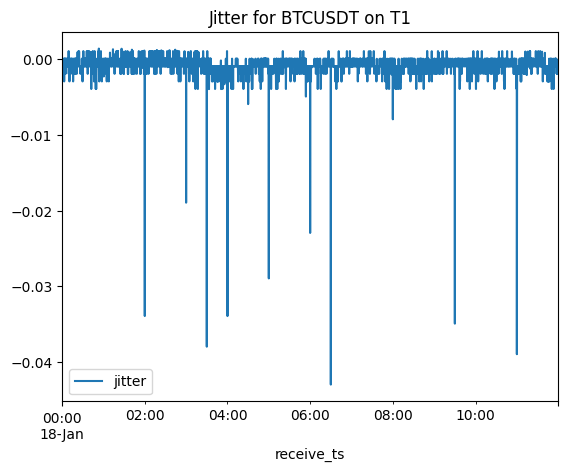

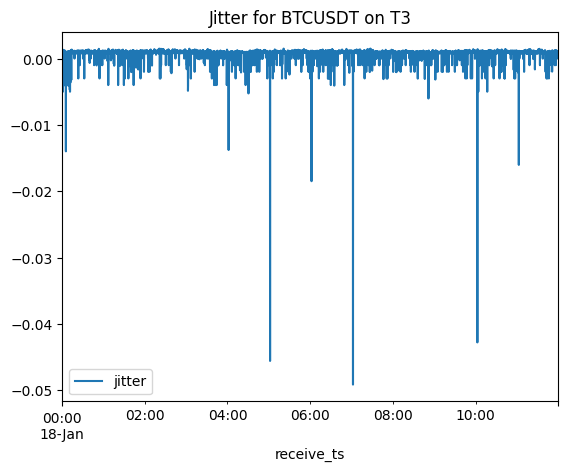

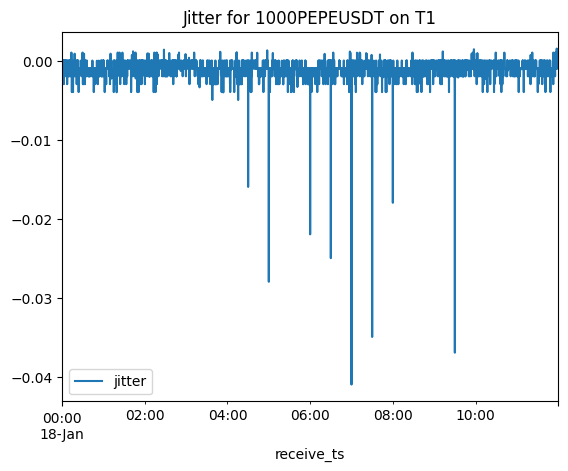

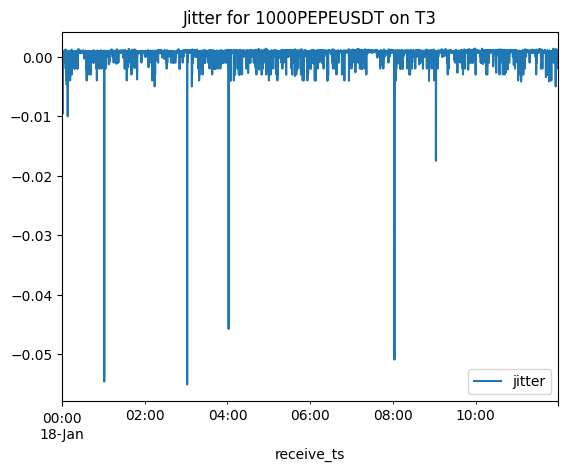

In [216]:
# Построим график Jitter для данных по 5 минутам с отрицательными значениями

for security in SECURITIES:
    for server in SERVERS:
        trade_data[security][server].resample("10s", on="receive_ts").min().plot(y="jitter", title=f"Jitter for {security} on {server}")
        plt.show()



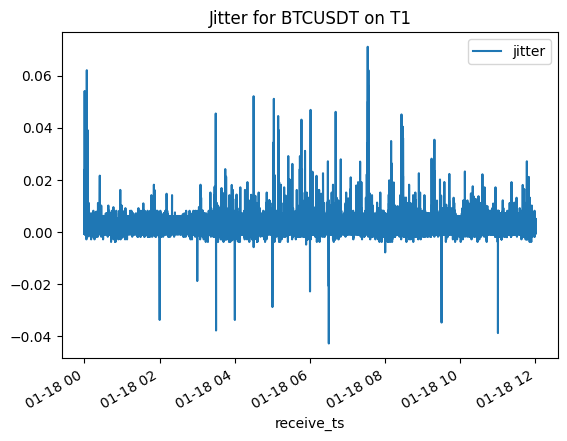

In [217]:
# Построим график не агрегированных данных для T1 и T3 для BTCUSDT
trade_data["BTCUSDT"]["T1"].plot(x="receive_ts", y="jitter", title="Jitter for BTCUSDT on T1")
plt.show()

# Теперь сгладим данные но datetime нужно привести к числовому формату
# trade_data["BTCUSDT"]["T1"]["receive_ts"] = trade_data["BTCUSDT"]["T1"]["receive_ts"].astype(int)
# trade_data["BTCUSDT"]["T1"]["exchange_ts"] = trade_data["BTCUSDT"]["T1"]["exchange_ts"].astype(int)
# trade_data["BTCUSDT"]["T1"]["jitter"] = (trade_data["BTCUSDT"]["T1"]["jitter"] * 10**6).astype(int)
# trade_data["BTCUSDT"]["T1"].sort_values().head()
# trade_data["BTCUSDT"]["T1"].rolling(window=1, on="jitter").plot(x="receive_ts", y="jitter", title="Jitter for BTCUSDT on T1")

In [219]:
# Выведем максимальные средние и минимальные значения по серверам
for security in SECURITIES:
    for server in SERVERS:
        print(f"Security: {security}, Server: {server}")
        print(f"Max: {trade_data[security][server]['jitter'].max()}")
        print(f"Mean: {trade_data[security][server]['jitter'].mean()}")
        print(f"Min: {trade_data[security][server]['jitter'].min()}")
        print()

Security: BTCUSDT, Server: T1
Max: 0.07105
Mean: 0.002780243169923095
Min: -0.042959

Security: BTCUSDT, Server: T3
Max: 0.038803
Mean: 0.0022730764083949
Min: -0.049169

Security: 1000PEPEUSDT, Server: T1
Max: 0.076513
Mean: 0.0025960346241058335
Min: -0.04095

Security: 1000PEPEUSDT, Server: T3
Max: 0.024042
Mean: 0.002107680999404143
Min: -0.055123



## Выводы

- Для инструмента `BTCUSDT` на сервере `T1` наблюдается большой разброс значений Jitter, в то время как на сервере `T3` значения Jitter более стабильны.
- Средние значения Jitter для всех данных на сервере `T1` выше, чем на сервере `T3`.
- Максимальные значения Jitter для всех данных на сервере `T1` выше, чем на сервере `T3`.
- Минимальные значения Jitter для всех данных на сервере `T1` ниже, чем на сервере `T3`.